In [1]:
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")
import wrangle as wra
import env
import explore as exp
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

### 1. Select a dataset with a continuous target variable.

In [2]:
zillow_query = """
        select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt,
        taxamount, fips
        from properties_2017
        where propertylandusetypeid = '261';
        """

zillow_df = wra.get_zillow_data(zillow_query)

zillow_df.head()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
df = zillow_df

In [4]:
df = wra.wrangle_zillow(df)

In [5]:
df.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
4,4,2.0,3633,296425,2005,6941.39,LA
6,3,4.0,1620,847770,2011,10244.94,LA
7,3,2.0,2077,646760,1926,7924.68,LA
18,3,1.0,1244,169471,1950,2532.88,LA
19,3,2.0,1300,233266,1950,3110.99,LA


In [6]:
# Encode the 'county' column using get_dummies()
county_dummies = pd.get_dummies(df['county'], prefix='county')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, county_dummies], axis=1)

In [7]:
df.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county,county_LA,county_Orange,county_Ventura
4,4,2.0,3633,296425,2005,6941.39,LA,1,0,0
6,3,4.0,1620,847770,2011,10244.94,LA,1,0,0
7,3,2.0,2077,646760,1926,7924.68,LA,1,0,0
18,3,1.0,1244,169471,1950,2532.88,LA,1,0,0
19,3,2.0,1300,233266,1950,3110.99,LA,1,0,0


In [8]:
# split the data
train, validate, test = wra.split_data(df)

In [9]:
# define the scale
to_scale = ['bedroomcnt','bathroomcnt','squarefeet','yearbuilt','taxamount', 'county_LA', 'county_Orange', 'county_Ventura']

In [10]:
# scale the data using function
train_scaled, validate_scaled, test_scaled = exp.scale_data(train, validate, test, to_scale)

In [11]:
# build your X-train, y_train (target)
X_train, X_validate, X_test = train_scaled[['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount', 'county_LA', 'county_Orange', 'county_Ventura']], validate_scaled[['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount', 'county_LA', 'county_Orange', 'county_Ventura']], test_scaled[['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount', 'county_LA', 'county_Orange', 'county_Ventura']]

y_train, y_validate, y_test = train.taxvalue, validate.taxvalue, test.taxvalue

In [12]:
# look at scaled and encoded data we'll be feeding into the models
X_train.head()

,bedroomcnt,bathroomcnt,squarefeet,yearbuilt,taxamount,county_LA,county_Orange,county_Ventura
636038,0.1250,0.05,0.037161,0.711628,0.029535,0.0,0.0,1.0
640751,0.1250,0.05,0.033816,0.688372,0.079354,1.0,0.0,0.0
794808,0.2500,0.10,0.062141,0.739535,0.017276,0.0,1.0,0.0
592271,0.2500,0.15,0.095380,0.986047,0.147038,0.0,0.0,1.0
1445194,0.1875,0.10,0.052851,0.874419,0.047340,1.0,0.0,0.0


In [13]:
y_train.head()

636038     169180
640751     396000
794808      70460
592271     630704
1445194    160104
Name: taxvalue, dtype: int64

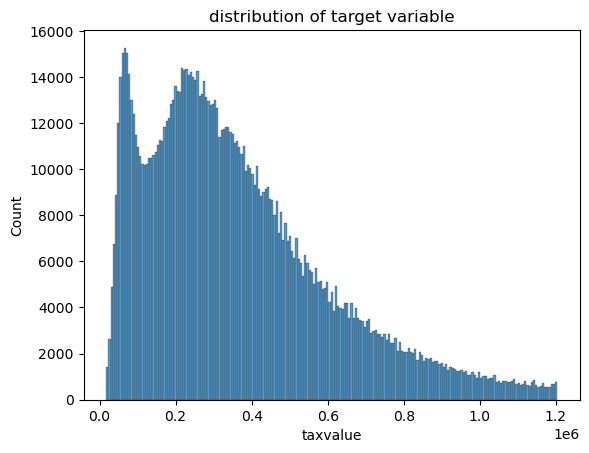

In [14]:
# plot target (taxvalue) distribution
sns.histplot(y_train)
plt.title('distribution of target variable')
plt.show()

* What type of distribution is this?

In [15]:
# find your baseline with the target mean
baseline = y_train.mean()
baseline

363534.3761597599

In [16]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [17]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([363534.37615976, 363534.37615976, 363534.37615976, 363534.37615976,
       363534.37615976])

In [18]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(243177.22748260814, 0.0)

In [19]:
# we will use this metrics df to feed the different models in so we can see their performance side by side
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,243177.227483,0.0


### Ordinary Least Squares (OLS)

* OLS is our standard linear regression algorithm and is computed by minimizing the sum of squared differences in the linear model (residual) with the actual data points

In [20]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=4)

#fit it
rfe.fit(X_train, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train)

#use it on validate
X_val_rfe = rfe.transform(X_validate)

In [21]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['taxamount' 'county_LA' 'county_Orange' 'county_Ventura']


* build model from top feature

In [22]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [23]:
pred_lr1[:10]

array([169909.75, 373303.5 , 104473.75, 749699.5 , 215335.25,  71667.75,
       269711.75, 473363.75, 371077.75, 283326.25])

* evaluate

In [24]:
#train
metrics_reg(y_train, pred_lr1)

(60621.98185698121, 0.9378538176308573)

In [25]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(61369.75103264432, 0.9366476041214626)

In [26]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,243177.227483,0.000000
1,ols_1,61369.751033,0.936648


* examine the model

In [27]:
lr1.intercept_

-1573427914214382.5

In [28]:
lr1.coef_

array([4.93426974e+06, 1.57342791e+15, 1.57342791e+15, 1.57342791e+15])

In [29]:
print(f'taxvalue = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*taxamount')

taxvalue = -1.57e+15 + 4.9e+06*taxamount


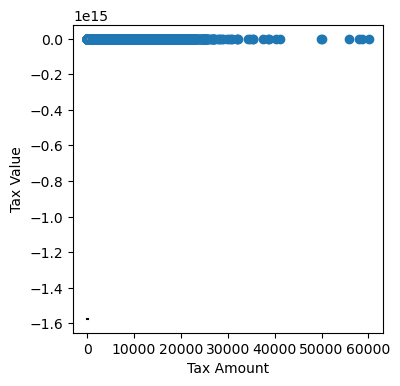

In [30]:
plt.figure(figsize=(4, 4))

plt.scatter(train.taxamount, train.taxvalue)

#build prediction line from intercept and slope
x_val = np.array([-2, 100]).reshape(-1, 1)
plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='black')

#intercept line
plt.hlines(22, -5, 100, ls=':', color='red')  

#(0,0) axis
plt.hlines(0, -5, 100, ls='--', color='grey')
plt.vlines(0, -10, 100, ls='--', color='grey')
 
plt.xlabel('Tax Amount')
plt.ylabel('Tax Value')
plt.show()

### Multiple Regression

* model using OLS

In [31]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(X_train, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(X_train)

#use it on validate
pred_val_lr2 = lr2.predict(X_validate)

In [32]:
pred_lr2[:10]

array([171630.37109375, 368004.10546875, 103682.0703125 , 733128.71875   ,
       196374.47265625,  77408.8671875 , 263667.15625   , 469085.4296875 ,
       366734.078125  , 299175.4609375 ])

* evaluate

In [33]:
#train 
metrics_reg(y_train, pred_lr2)

(59897.73609411718, 0.9393298580983809)

In [34]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(60638.56699102997, 0.9381482232053454)

In [35]:
#add to my metrics df
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,243177.227483,0.000000
1,ols_1,61369.751033,0.936648
2,ols,60638.566991,0.938148


### LassoLars
* LASSO = Least Absolute Shrinkage and Selection Operator

* LARS = Least Angle Regression

* Performs intrinsic feature selection and noise reduction to avoid overfitting
* The most important hyperparameter is alpha
    * alpha determines the degree of regularization applied to the model
    * The lowest alpha is zero, and this represents no regularization (identical to OLS)
    * There is no limit to alpha, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero
    * Generally speaking, the higher the alpha, the lower your risk for overfitting
    * alpha = 1.0 is a good place to start

* alpha = 0, identical to OLS

In [36]:
#make it
lars = LassoLars(alpha=0)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)

In [37]:
pd.Series(lars.coef_, index=lars.feature_names_in_)

bedroomcnt       -6.889046e+04
bathroomcnt       7.099862e+04
squarefeet        2.578356e+05
yearbuilt        -1.014722e+05
taxamount         4.900803e+06
county_LA        -4.287723e+04
county_Orange     0.000000e+00
county_Ventura    6.399368e+03
dtype: float64

In [38]:
lr2.coef_

array([-6.90012808e+04,  7.10180208e+04,  2.57834204e+05, -1.01474144e+05,
        4.90080326e+06, -3.51167176e+13, -3.51167175e+13, -3.51167175e+13])

* alpha=1

In [39]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)
pred_val_lars = lars.predict(X_validate)

In [40]:
#train
metrics_reg(y_train, pred_lars)

(60026.15751652223, 0.9390694242724655)

In [41]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(60757.28678774221, 0.9379057960200736)

In [42]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,243177.227483,0.000000
1,ols_1,61369.751033,0.936648
2,ols,60638.566991,0.938148
3,lars,60757.286788,0.937906


### Polynomial Regression
* process

* create new features based on degrees
* fit on a linear regression model

* create new features based on degrees

In [43]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

* fit on a linear regression model

In [44]:
#make it
pr = LinearRegression()

#fit it
pr.fit(X_train_degree2, y_train)

#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

* evaluate

In [45]:
#train
metrics_reg(y_train, pred_pr)

(54439.5494521444, 0.9498832108379707)

In [46]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr)
rmse, r2

(54414.20227263176, 0.9501943222498593)

In [47]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,243177.227483,0.000000
1,ols_1,61369.751033,0.936648
2,ols,60638.566991,0.938148
3,lars,60757.286788,0.937906
4,poly_2,54414.202273,0.950194


### Generalized Linear Model (GLM)
The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor method to create a GLM using sklearn.

About power:

power = 0: Normal Distribution
power = 1: Poisson Distribution
power = (1,2): Compound Distribution
power = 2: Gamma Distribution
power = 3: Inverse Gaussian Distribution

In [48]:
#make it
glm = TweedieRegressor(power=1, alpha=0)

#fit it
glm.fit(X_train, y_train)

#use it
pred_glm = glm.predict(X_train)
pred_val_glm = glm.predict(X_validate)

* evaluate

In [49]:
#train
metrics_reg(y_train, pred_glm)

(1073651.4223510372, -18.493095129941167)

In [50]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_glm)
rmse, r2

(3107388.847510132, -161.4222514932712)

In [51]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,2.431772e+05,0.000000
1,ols_1,6.136975e+04,0.936648
2,ols,6.063857e+04,0.938148
3,lars,6.075729e+04,0.937906
4,poly_2,5.441420e+04,0.950194
5,glm,3.107389e+06,-161.422251


### Evaluate on Best Model

In [52]:
#use it
pred_test = pr.predict(X_test_degree2)
pred_test

array([-23336., 474552., 435216., ...,  64296., 433688., 152200.])

In [53]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

(55620.64151202772, 0.9473399085937155)

* plot actuals vs predicted

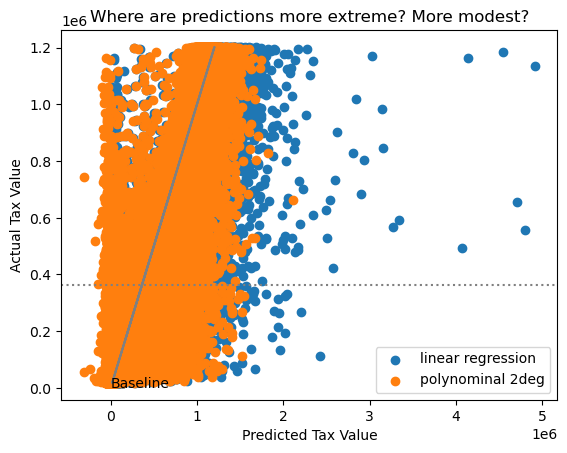

In [54]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
# plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual Tax Value")
plt.xlabel("Predicted Tax Value")
plt.legend()

plt.show()